# Richards equation

#Simple 1D Richards' Equation Model

This is a 1D Richards' equation model, written by Andrew Ireson, 3 November 2015.   
Downloaded from: https://github.com/amireson/RichardsEquation/tree/master  
Modified by Guo-Shiuan Lin, 2 August, 2023.

## In this assignment, you should get three different figures (1,2,3 as shown below) for each conditions (1,2,3,4). 
- If there are same plots (e.g., same soil properties from the same soil), don't need to show them in the report again.
- Mainly show the plots where a change is expected to be observed

In [1]:
# Import all of the basic libraries (you will always need these)
from matplotlib import pyplot as pl
import numpy as np

# Import a library that contains soil moisture properties and functions
# to import successfully, the vanGenuchten.py file must be in the same folder as this Jupyter notebook!
import vanGenuchten as vg

# Import ODE solvers
from scipy.interpolate import interp1d
from scipy.integrate import odeint

# Select which soil properties to use. In the first example, we use the Hygiene Sand Stone
p=vg.HygieneSandstone() # TouchetSiltLoam() # 

In [2]:
# Richards equation solver
# This is a function that calculated the right hand side of Richards' equation. 
# You will not need to modify this function!
# This block of code must be executed so that the function can be later called.

def RichardsModel(psi,t,dz,n,p,vg,qTop,qBot,psiTop,psiBot):
       
    # Basic properties:
    C=vg.CFun(psi,p)
   
    # initialize vectors:
    q=np.zeros(n+1)
    
    # Upper boundary
    if qTop == []:
        KTop=vg.KFun(np.zeros(1)+psiTop,p)
        q[n]=-KTop*((psiTop-psi[n-1])/dz*2+1)
    else:
        q[n]=qTop
    
    # Lower boundary
    if qBot == []:
        if psiBot == []:
            # Free drainage
            KBot=vg.KFun(np.zeros(1)+psi[0],p)
            q[0]=-KBot
        else:
            # Type 1 boundary
            KBot=vg.KFun(np.zeros(1)+psiBot,p)
            q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)    
    else:
        # Type 2 boundary
        q[0]=qBot
    
    # Internal nodes
    i=np.arange(0,n-1)
    Knodes=vg.KFun(psi,p)
    Kmid=(Knodes[i+1]+Knodes[i])/2.0
    
    j=np.arange(1,n)
    q[j]=-Kmid*((psi[i+1]-psi[i])/dz+1.0)
        
    
    # Continuity
    i=np.arange(0,n)
    dpsidt=(-(q[i+1]-q[i])/dz)/C
    
    return dpsidt

## Condition 1

# Figure 1: hydraulic properties of the soil

In [3]:
# Three plots. Plot three soil properties (theta, C, K calculated below) on y with psi on x. 
psi = np.linspace(-10,0)
theta = vg.thetaFun(psi,p)
C=vg.CFun(psi,p)
K=vg.KFun(psi,p)

# Your code here. Use pl.subplots(3,1, sharex=True) to create 3 plots in one column with shared x axis


In [4]:
# This block of code sets up and runs the model. You must run it again after you change some parameters (as required by the assignment)

# Boundary conditions
qTop=-0.01 # m/day. It is negative because the direction of infiltration is downward
qBot=[]
psiTop=[] # top boundary condition 
psiBot= 0 # set to [] to change to set bottom boundary condition as free drainage 

# Grid in space
dz=0.1 # meter
ProfileDepth=5 # meter
z=np.arange(dz/2.0,ProfileDepth,dz)
n=z.size

# Grid in time
t = np.linspace(0,10,101) # 10 days with 101 time steps

# Initial conditions
psi0=-z

# Solve. The odeint function solves the system
psi=odeint(RichardsModel,psi0,t,args=(dz,n,p,vg,qTop,qBot,psiTop,psiBot),mxstep=5000000);

print("Model run successfully")  

C:\Users\glin\AppData\Local\Temp\ipykernel_12336\4283632028.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)


Model run successfully


In [5]:
# Post process model output to get useful information

# Get water content
theta=vg.thetaFun(psi,p)

# Get total profile storage
S=theta.sum(axis=1)*dz

# Get change in storage [dVol]
dS=np.zeros(S.size)
dS[1:]=np.diff(S)/(t[1]-t[0])

# Get infiltration flux
if qTop == []:
    KTop=vg.KFun(np.zeros(1)+psiTop,p)
    qI=-KTop*((psiTop-psi[:,n-1])/dz*2+1)
else:
    qI=np.zeros(t.size)+qTop
    
# Get discharge flux
if qBot == []:
    if psiBot == []:
        # Free drainage
        KBot=vg.KFun(psi[:,0],p)
        qD=-KBot
    else:
        # Type 1 boundary
        KBot=vg.KFun(np.zeros(1)+psiBot,p)
        qD=-KBot*((psi[:,0]-psiBot)/dz*2+1.0)
else:
    qD=np.zeros(t.size)+qBot
    

# Figure 2

Text(0.5, 0, '$\\theta$ [-]')

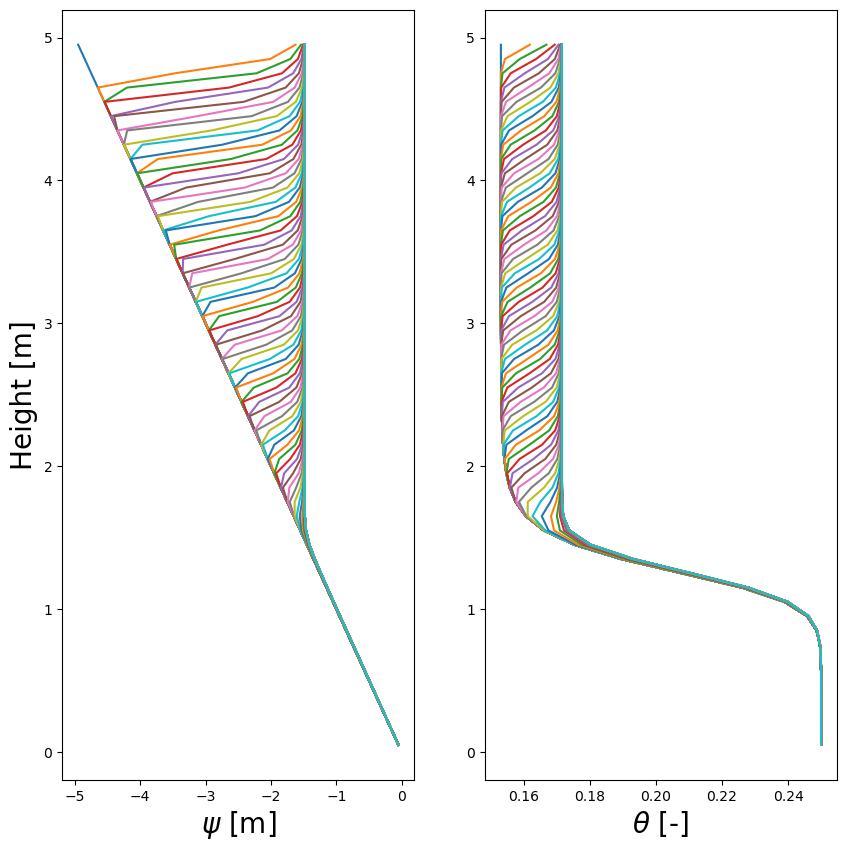

In [6]:
# Plot vertical profiles
pl.rcParams['figure.figsize'] = (10.0, 10.0)
for i in range(0,t.size-1): ### set the time to plot
    pl.subplot(121)
    pl.plot(psi[i,:],z)
    pl.subplot(122)
    pl.plot(theta[i,:],z)

pl.subplot(121)
pl.ylabel('Height [m]',fontsize=20) 
# the Height for soil may seem confusing. Imaging there is a soil column standing on the ground. 
# The bottom of the soil colum touching the ground is height=0
# the top of the soil column 5 meters above the ground is height=5
pl.xlabel(r'$\psi$ [m]',fontsize=20)
pl.subplot(122)
pl.xlabel(r'$\theta$ [-]',fontsize=20)

# each colored line represents the vertical profile at a time step (so 101 lines in total) 

# Figure 3

Text(0, 0.5, '$m^3$/days')

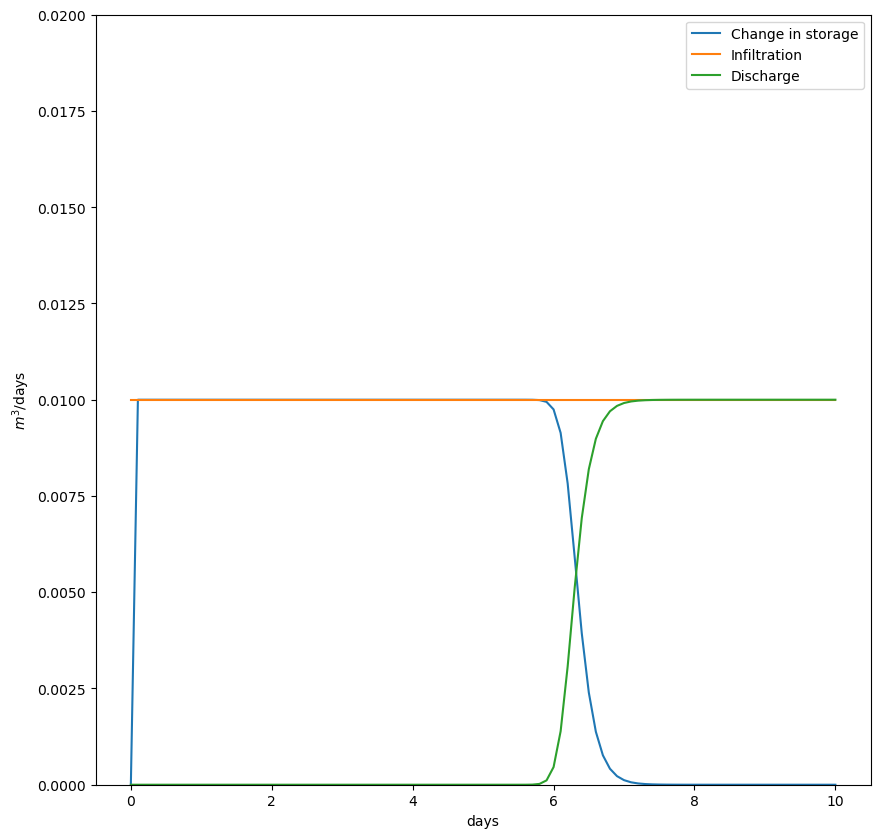

In [7]:
# Plot timeseries
dt = t[2]-t[1]
pl.plot(t,dS,label='Change in storage')
# pl.hold(True)
pl.plot(t,-qI,label='Infiltration')
pl.plot(t,-qD,label='Discharge')
pl.legend(loc=1)
pl.ylim((0,0.02)) # You need to choose a reasonble range yourself after changing the parameters (as required by the assignment)
pl.xlabel('days')
pl.ylabel('$m^3$/days')

## Condition 2. Change the soil type and compare the results

In [8]:
# Choose another soil type
p=vg.GuelphLoamDrying() # or p=vg.BeitNetofaClay(), p=vg.GuelphLoamWetting(), p=vg.SiltLoamGE3(), p=vg.TouchetSiltLoam() 

# run the model and plot again

## Condition 3. Change the infiltration rate and compare

In [9]:
qTop=-0.001 # or -0.005 m/day or other number you want to try

# run the model and plot again

## Condition 4. Change the boundary condition to free drainage and compare

In [10]:
# run the model and plot again